# imports

In [6]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import os


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Creating Generator**

In [25]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model


# **Merging Discriminator and Generator**

In [26]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


# **load data**

In [27]:
from PIL import Image, ImageOps
import glob
def load_real_samples(image_res=32, sample_size=25000):
  x_train = []
  paths = glob.glob('/content/cats_and_dogs/train/*.jpg')
  random.shuffle(paths)
  
  for path in paths[:sample_size]:
    try:
      if ~isinstance(path, list) and os.path.isfile(path) and os.path.getsize(path) > 0:
        im = Image.open(path)
        im = ImageOps.fit(im, (image_res, image_res), Image.ANTIALIAS)
        im = np.asarray(im)
        if im.shape != (image_res, image_res, 3):
          print(path +' is not 3d.')
          continue
        # print(im.shape)
        im = (im.astype(np.float32) - 127.5) / 127.5
        x_train.append(im.reshape(image_res,image_res,3))
        # X_train.append(im.reshape(3, image_res, image_res))
    except:
      pass
  print("loading data is finished.")
  return np.asarray(x_train)

In [28]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [29]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


/content/cats_and_dogs/train/dog.12413.jpg is not 3d.
/content/cats_and_dogs/train/cat.1168.jpg is not 3d.
/content/cats_and_dogs/train/cat.6375.jpg is not 3d.
/content/cats_and_dogs/train/dog.736.jpg is not 3d.
/content/cats_and_dogs/train/dog.8886.jpg is not 3d.
/content/cats_and_dogs/train/cat.200.jpg is not 3d.
/content/cats_and_dogs/train/dog.8288.jpg is not 3d.
/content/cats_and_dogs/train/cat.4611.jpg is not 3d.
/content/cats_and_dogs/train/dog.245.jpg is not 3d.
/content/cats_and_dogs/train/dog.5092.jpg is not 3d.
/content/cats_and_dogs/train/cat.192.jpg is not 3d.
/content/cats_and_dogs/train/cat.4835.jpg is not 3d.
/content/cats_and_dogs/train/cat.4926.jpg is not 3d.
/content/cats_and_dogs/train/dog.12222.jpg is not 3d.
/content/cats_and_dogs/train/cat.7117.jpg is not 3d.
/content/cats_and_dogs/train/dog.9004.jpg is not 3d.
/content/cats_and_dogs/train/cat.6238.jpg is not 3d.
/content/cats_and_dogs/train/cat.11054.jpg is not 3d.
/content/cats_and_dogs/train/cat.6880.jpg is no

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

/content/cats_and_dogs/train/dog.6365.jpg is not 3d.
/content/cats_and_dogs/train/cat.10571.jpg is not 3d.
/content/cats_and_dogs/train/dog.4389.jpg is not 3d.
/content/cats_and_dogs/train/dog.10988.jpg is not 3d.
/content/cats_and_dogs/train/cat.7668.jpg is not 3d.
/content/cats_and_dogs/train/cat.2578.jpg is not 3d.
/content/cats_and_dogs/train/dog.4397.jpg is not 3d.
/content/cats_and_dogs/train/dog.5497.jpg is not 3d.
/content/cats_and_dogs/train/dog.2004.jpg is not 3d.
/content/cats_and_dogs/train/cat.10259.jpg is not 3d.
/content/cats_and_dogs/train/dog.9636.jpg is not 3d.
/content/cats_and_dogs/train/dog.6686.jpg is not 3d.
/content/cats_and_dogs/train/dog.10948.jpg is not 3d.
/content/cats_and_dogs/train/cat.4074.jpg is not 3d.
/content/cats_and_dogs/train/dog.6380.jpg is not 3d.
/content/cats_and_dogs/train/dog.2800.jpg is not 3d.
/content/cats_and_dogs/train/cat.9758.jpg is not 3d.
loading data is finished.


# **Train**

In [31]:
from matplotlib import pyplot
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  print(dataset.shape[0])
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, 1))
  return X, y

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=128):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=150, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
24929
>138, 26/194, d1=0.589, d2=0.529 g=1.307
24929
>138, 27/194, d1=0.617, d2=0.513 g=1.311
24929
>138, 28/194, d1=0.574, d2=0.502 g=1.193
24929
>138, 29/194, d1=0.520, d2=0.481 g=1.258
24929
>138, 30/194, d1=0.556, d2=0.492 g=1.389
24929
>138, 31/194, d1=0.519, d2=0.554 g=1.290
24929
>138, 32/194, d1=0.640, d2=0.609 g=1.181
24929
>138, 33/194, d1=0.553, d2=0.551 g=1.264
24929
>138, 34/194, d1=0.733, d2=0.546 g=1.335
24929
>138, 35/194, d1=0.565, d2=0.561 g=1.415
24929
>138, 36/194, d1=0.528, d2=0.547 g=1.238
24929
>138, 37/194, d1=0.587, d2=0.640 g=1.395
24929
>138, 38/194, d1=0.604, d2=0.492 g=1.284
24929
>138, 39/194, d1=0.529, d2=0.473 g=1.224
24929
>138, 40/194, d1=0.623, d2=0.603 g=1.216
24929
>138, 41/194, d1=0.542, d2=0.513 g=1.367
24929
>138, 42/194, d1=0.597, d2=0.547 g=1.142
24929
>138, 43/194, d1=0.549, d2=0.641 g=1.307
24929
>138, 44/194, d1=0.520, d2=0.425 g=1.221
24929
>138, 45/194, d1=0.586, d2=0.651 g=1.322
24929
>13

# **Plot results**

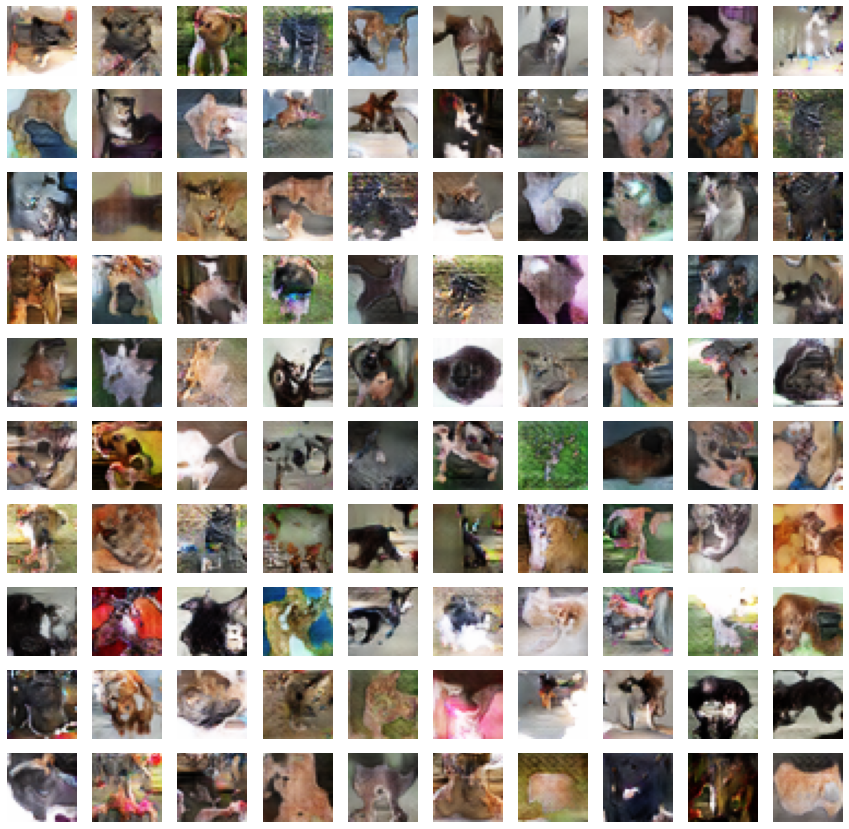

In [36]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	plt.savefig('answer.png')
	pyplot.show()

# load model
model = load_model('generator_model_150.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
from matplotlib.pyplot import figure
figure(figsize=(15,15))
create_plot(X, 10)
